In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from autophasemap import compute_elastic_kmeans, compute_euclidean_kmeans, BaseDataSet

In this notebook, we apply the `autophasemap` algorithm to a synthetic phasemap with parabolic phase region. 
Each region is assigned a Gaussian curve $g(t)$ with either a single, double, or triple peak but can be randomly warped along the function domain $t$. 

References:
- [elastic k-means](https://arxiv.org/pdf/2011.12397.pdf)

In [8]:
# create synthetic data making use of the BaseDataSet that provides essentials components. 
# This example dataset is generated according to the Section 4 in the elastic k-means paper.
class DataSet(BaseDataSet):
    def __init__(self, C, P, n_domain = 100):
        super().__init__(n_domain=n_domain)
        self.t = np.linspace(0,1, num=self.n_domain)
        self.N = C.shape[0]
        self.P = P
        self.C = C
        self.n_clusters = 3
        
    def g(self, t, p):
        out = np.zeros(self.t.shape)
        for i in range(1,p+1):
            zi = np.random.normal(1, 0.1)
            mean = (2*i-1)/(2*p)
            std = 1/(3*p)
            out += zi*self.phi(t, mean, std)

        return out
    
    def phi(self, t, mu, sigma):
        factor = 1/(2*(sigma**2))
        return np.exp(-factor*(t-mu)**2)
    
    def gamma(self):
        a = np.random.uniform(-3, 3)
        if a==0:
            gam = self.t
        else:
            gam = (np.exp(a*self.t)-1)/(np.exp(a)-1)
        return gam
    
    def generate(self):
        self.F = [self.g(self.gamma(), self.P[i]) for i in range(self.N)]

        return

We synthetically specify parabolic regions and visualize them on the two dimensional design space

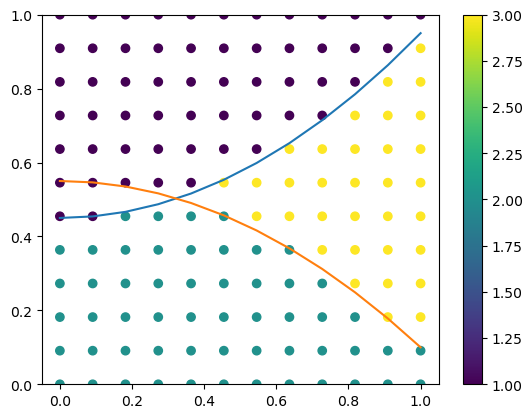

In [9]:
n_grid = 12
x = np.linspace(0,1, n_grid)
y = np.linspace(0,1, n_grid)
X,Y = np.meshgrid(x,y)
points = np.vstack([X.ravel(), Y.ravel()]).T
phase1 = lambda x : 0.5*(x)**2+0.45
phase2 = lambda x : -0.45*(x)**2+0.55

# plot the dummy phase map
def get_label(c):
    if c[1]-phase1(c[0])>0:
        label = 1
    elif c[1]-phase2(c[0])<0:
        label = 2
    else:
        label = 3
        
    return label

labels = [get_label(p) for p in points]

fig, ax = plt.subplots()
sc = ax.scatter(points[:,0], points[:,1], c=labels)
ax.plot(x, phase1(y))
ax.plot(x, phase2(y))
ax.set_ylim([0,1])
cbar = plt.colorbar(sc)
plt.show()

Now, we can visualize the dataset that contains three phases...

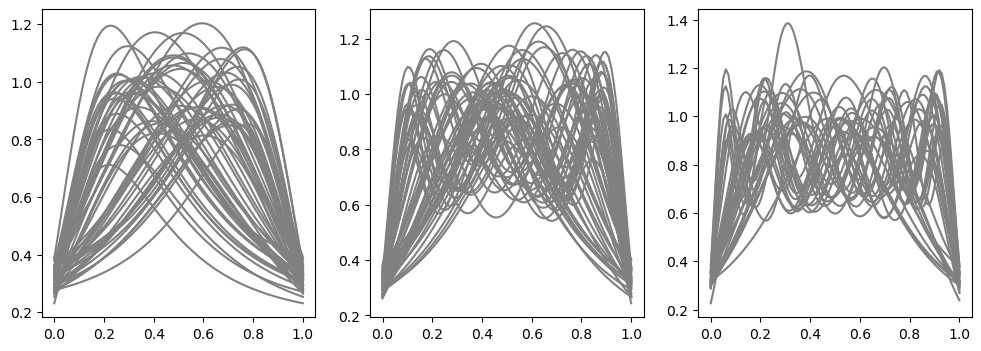

In [10]:
n_domain = 200

data = DataSet(points, labels)
data.generate()
fig, axs = plt.subplots(1, 3, figsize=(4*3, 4))
for i in range(data.N):
    axs[data.P[i]-1].plot(data.t, data.F[i], color='grey')
plt.show()

In [11]:
def plot(data, out):
    fig, axs = plt.subplots(1,4, figsize=(4*4, 4))
    for k, ax in enumerate(axs):
        if k==3:
            ax.scatter(data.C[:,0], data.C[:,1], c=out.delta_n)
            continue
        Mk = np.argwhere(out.delta_n==k).squeeze()
        for i in Mk:
            ax.plot(data.t, out.fik_gam[i,k,:], color='grey')
        
        ax.plot(data.t, out.templates[k], lw=3.0, color='tab:red') 
        ax.axis('off')
    plt.show()

#### Compute the phasemap using the algorithm presented in this manuscript

(0:00:02.619431)	Iteration : 0	Error : 0.4642
(0:00:15.341516)	Iteration : 10	Error : 0.0076
(0:00:27.647996)	Iteration : 20	Error : 0.0269
(0:00:39.969773)	Iteration : 30	Error : 0.0159
(0:00:52.234727)	Iteration : 40	Error : 0.0210
(0:01:04.639464)	Iteration : 50	Error : 0.0104
(0:01:17.069766)	Iteration : 60	Error : 0.0123
(0:01:29.508169)	Iteration : 70	Error : 0.0085
(0:01:41.978640)	Iteration : 80	Error : 0.0059
(0:01:56.635313)	Iteration : 90	Error : 0.0232
Total iterations 99	Error : 0.0098 and took 0:02:08.599503


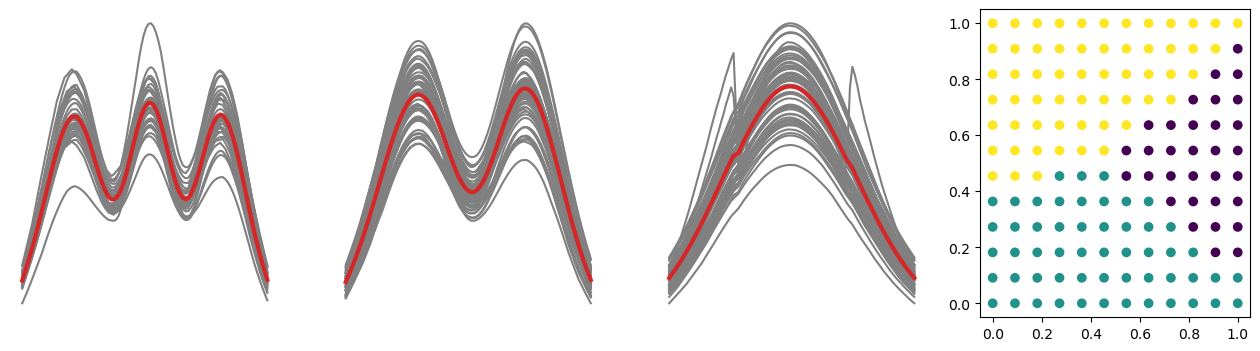

In [12]:
N_CLUSTERS = 3
MAX_ITER = 100
VERBOSE = 3

out_elastic = compute_elastic_kmeans(data, N_CLUSTERS, 
    max_iter=MAX_ITER, 
    verbose=VERBOSE, 
    smoothen=True
    )
plot(data, out_elastic)

#### Compare it with Euclidean kmeans clustering as a baseline 


Error : 271.7104 and took 0:00:00.044131


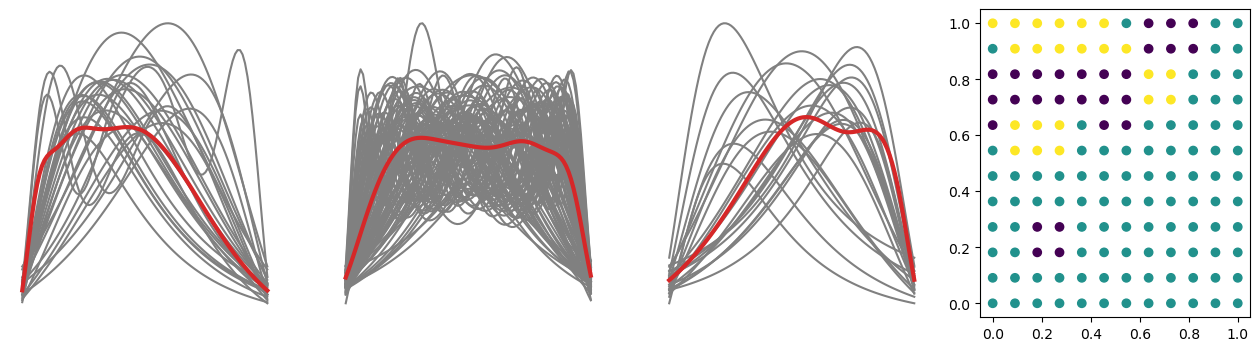

In [13]:
N_CLUSTERS = 3
MAX_ITER = 300
VERBOSE = 0

out_euclidean = compute_euclidean_kmeans(data, N_CLUSTERS, 
    max_iter=MAX_ITER, 
    verbose=VERBOSE, 
    smoothen=True
    )
plot(data, out_euclidean)